# Stack Exchange Data Analysis

## What is the most popular content?

In this projects, I will explore the open data of Stack Exchange Data Science. It is accessible via their Data Explorer by writing SQL queries.

### Post types

First let's check all post types by joining Posts table and PostTypes table.

In [ ]:
SELECT
    Posts.PostTypeId,
    PostTypes.Name AS PostType,
    COUNT(Posts.Id) AS NumOfPosts
FROM Posts
INNER JOIN PostTypes
ON Posts.PostTypeId = PostTypes.Id
GROUP BY Posts.PostTypeId, PostTypes.Name
ORDER BY Posts.PostTypeId;

| PostTypeId | PostType            | NumOfPosts |
| ---------- | ------------------- | -----------|
| 1          | Question            | 28543      |
| 2          | Answer              | 32066      |
| 4          | TagWikiExcerpt      | 301        |
| 5          | TagWiki             | 301        |
| 6          | ModeratorNomination | 11         |
| 7          | WikiPlaceholder     | 1          |

It shows that most posts are questions and answers. Even if it happens to be the case such that other kinds of posts are very popular, they are just outliers and irrelevant for us. In this project I will focus on question posts.

### Useful tables

'Posts', 'Tags' seem promising.

### Questions in 2019

In this project, I focused my analysis on questions in 2019.
Futhurmore, I queried only the following set of columns from Posts table:

- Id: An identification number for the post.
- PostTypeId: An identification number for the type of post.
- CreationDate: The date and time of creation of the post.
- Score: The post's score.
- ViewCount: How many times the post was viewed.
- Tags: What tags were used.
- AnswerCount: How many answers the question got (only applicable to question posts).
- FavoriteCount: How many times the question was favored (only applicable to question posts).

In [ ]:
SELECT
    Id,
    PostTypeId,
    CreationDate,
    Score,
    ViewCount,
    Tags,
    AnswerCount,
    FavoriteCount
FROM Posts
WHERE YEAR(CreationDate) = 2019;

Stack Exchange Data Explorer lets us download results of queries as csv file. I stored it as '2019_questions.csv'

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [171]:
questions = pd.read_csv('2019_questions.csv', parse_dates=['CreationDate'])

In [172]:
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [173]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


#### How many missing values are there in each column?

In [174]:
questions.isnull().sum()

Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    7432
dtype: int64

In [175]:
questions['FavoriteCount'].value_counts()

1.0     953
2.0     205
0.0     175
3.0      43
4.0      12
5.0       8
6.0       4
7.0       4
11.0      1
8.0       1
16.0      1
Name: FavoriteCount, dtype: int64

#### Can we fix the missing values somehow?

A. Yes. Imputing with 0 would be the best.

In [176]:
questions.fillna(0, inplace=True)

#### Are the types of each column adequate?

A. No. FavoriteCount column should be integer.

In [177]:
questions['FavoriteCount'] = questions['FavoriteCount'].astype(int)

#### What can we do about the Tags column?

A. A set of <> represents a single tag and we can parse tags by this.

In [178]:
questions['Tags'] = questions['Tags'].str.replace('><', ',').str.strip('<>')

In [179]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 483.5+ KB


#### How many times was each tag used?

In [180]:
# Flatten out all elements in Tags column
tags = []
for l in questions['Tags'].str.split(',').tolist():
    for tag in l:
        tags.append(tag)

# Disctionary of tag: occurrences
tag_count = {tag: tags.count(tag) for tag in set(tags)}

In [181]:
# Top 20 most used tags
most_used = pd.DataFrame.from_dict(tag_count, orient='index')
most_used.columns= ['Count']
most_used = most_used.sort_values(by='Count', ascending=False).head(20)

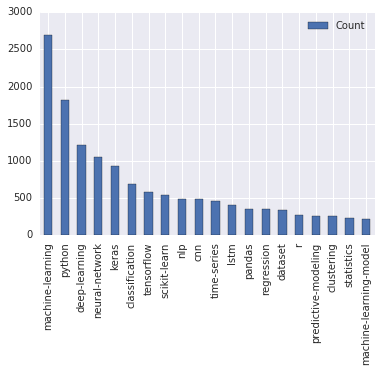

In [182]:
plt.figure(figsize=(10,5))
most_used.plot.bar()

#### How many times was each tag viewed?

In [183]:
def count_views(tag_viewed: dict, tags: list, view_count: int):
    """
    Store view count to tags the post is labeled.
    tag_viewed: dictionary to store tags and their acquired views
    tags: questions['Tags']
    view_count: questions['ViewCount']
    """
    for tag in tags:
        tag_viewed[tag] += view_count
    return None

# Initialize the dictionary to store view count
tag_viewed = dict.fromkeys(tag_count.keys(), 0)

# Repeat for all rows
questions.apply(lambda row: count_views(tag_viewed, row['Tags'].split(','), row['ViewCount']), axis=1)
None

In [184]:
# Top 20 most viewed tags
most_viewed = pd.DataFrame.from_dict(tag_viewed, orient='index')
most_viewed.columns= ['ViewCount']
most_viewed = most_viewed.sort_values(by='ViewCount', ascending=False).head(20)

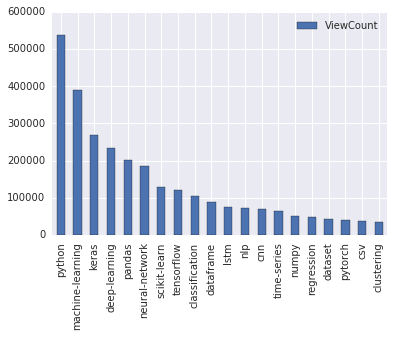

In [185]:
plt.figure(figsize=(10,5))
most_viewed.plot.bar()

In [186]:
# Merge two to spot tags appearing only one of them
used_viewed = pd.merge(most_used, most_viewed, how="outer", left_index=True, right_index=True)
used_viewed.sort_values(by='Count', ascending=False)


,Count,ViewCount
machine-learning,2693.0,388499.0
python,1814.0,537585.0
deep-learning,1220.0,233628.0
neural-network,1055.0,185367.0
keras,935.0,268608.0
classification,685.0,104457.0
tensorflow,584.0,121369.0
scikit-learn,540.0,128110.0
nlp,493.0,71382.0
cnn,489.0,70349.0


#### How are each tags related?

In [187]:
# Count cooccurences of every pair
cooccur = pd.DataFrame(index=tag_viewed.keys(), columns=tag_viewed.keys()).fillna(0)

for tags in questions['Tags'].str.split(','):
    cooccur.loc[tags, tags] += 1

In [188]:
# Cooccurences of the most used tags
cooccur_most_used = cooccur.loc[most_used.index, most_used.index]
cooccur_most_used

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,time-series,lstm,pandas,regression,dataset,r,predictive-modeling,clustering,statistics,machine-learning-model
machine-learning,2693,499,429,366,195,259,106,188,113,124,131,71,62,119,99,63,123,61,89,139
python,499,1814,160,137,280,98,167,235,71,62,105,61,244,59,53,24,35,45,35,37
deep-learning,429,160,1220,305,247,59,136,16,72,160,44,103,1,21,32,5,32,2,12,19
neural-network,366,137,305,1055,235,65,108,24,24,118,33,69,1,42,20,9,13,8,11,10
keras,195,280,247,235,935,58,256,34,23,116,51,133,3,31,13,10,11,0,3,17
classification,259,98,59,65,58,685,20,47,35,20,25,20,3,34,28,10,27,12,19,21
tensorflow,106,167,136,108,256,20,584,15,11,57,9,43,3,9,9,1,6,0,0,9
scikit-learn,188,235,16,24,34,47,15,540,12,0,12,2,37,37,9,1,12,24,6,18
nlp,113,71,72,24,23,35,11,12,493,7,0,19,3,2,11,4,1,9,3,4
cnn,124,62,160,118,116,20,57,0,7,489,8,24,1,6,11,2,6,0,1,4


In [189]:
for i in cooccur_most_used.index:
    cooccur_most_used.loc[i, i] = np.nan

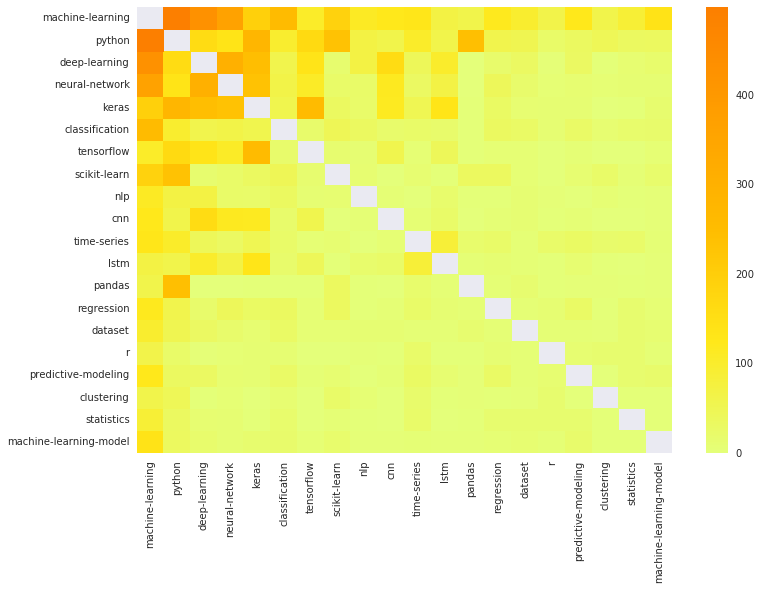

In [190]:
plt.figure(figsize=(12, 8))
sns.heatmap(cooccur_most_used, cmap='Wistia')

#### It can be seen that the most used tags tend to appear together with one anither. However this does not necessarily tell that these tags are legitimately correlated.

#### What are the most popular tags?

Tags that commonly appear in top 10 of both used and viewed are he following: python, machine-learning, deep-learning, neural-network, keras, tensorflow, classification, scikit-learn.
These indicate deep learning, especially classification implemented with python, is the most popular topic right now.

## Is this a long-lasting demand?

### Questions of all years

In [191]:
all_q = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])

In [192]:
all_q['Tags'] = all_q['Tags'].str.replace('><', ',').str.strip('<>')

In [193]:
all_q.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"python,keras,tensorflow,cnn,probability"
1,45418,2019-02-12 00:50:39,neural-network
2,45422,2019-02-12 04:40:51,"python,ibm-watson,chatbot"
3,45426,2019-02-12 04:51:49,keras
4,45427,2019-02-12 05:08:24,"r,predictive-modeling,machine-learning-model,s..."


#### Which tags should we regard as related to deep learning?

In [194]:
most_used

,Count
machine-learning,2693
python,1814
deep-learning,1220
neural-network,1055
keras,935
classification,685
tensorflow,584
scikit-learn,540
nlp,493
cnn,489


In [195]:
# Label if each question is related to deep learning
def is_deep_learning(tags: list):
    """
    Return 1 if tags contain deep learning related tags.
    """
    dl_tags = ['deep-learning', 'neural-network', 'keras', 'tensorflow', 'nlp', 
          'cnn', 'lstm']
    if any(tag in dl_tags for tag in tags):
        return 1
    else:
        return 0
    

In [196]:
all_q['DeepLearning'] = all_q['Tags'].str.split(',').apply(is_deep_learning)

In [197]:
all_q.sample(5)

,Id,CreationDate,Tags,DeepLearning
19325,33548,2018-06-23 13:00:16,"python,neural-network,deep-learning,keras,rnn",1
10520,8875,2015-11-17 18:56:02,"similarity,information-retrieval",0
4668,39057,2018-10-02 09:06:57,"deep-learning,tensorflow,training,dqn,keras-rl",1
476,24458,2017-11-07 17:12:14,"deep-learning,tensorflow,pytorch",1
13037,10000,2016-01-27 19:58:00,"bayesian-networks,pgm",0


### Count questions involving deep learning over a timeframe

In [198]:
# Earliest records
all_q.sort_values(by='CreationDate').head()

,Id,CreationDate,Tags,DeepLearning
65,5,2014-05-13 23:58:30,machine-learning,0
66,7,2014-05-14 00:11:06,"education,open-source",0
67,14,2014-05-14 01:25:59,"data-mining,definitions",0
68,15,2014-05-14 01:41:23,databases,0
69,16,2014-05-14 01:57:56,"machine-learning,bigdata,libsvm",0


#### I choose quarter of year as timeframe. 

Note that 2014 is missing its first quarter.

In [207]:
# Generate year+quarter label from datetime
def label_quarter(date):
    """
    Return form such as '19Q2'
    """
    year = date.year
    quarter = (date.month - 1)//3 + 1
    label = str(year)[2:] + 'Q' + str(quarter)
    return label

In [208]:
# Make new column 'Quarter'
all_q['Quarter'] = all_q['CreationDate'].apply(label_quarter)

In [214]:
quarterly = all_q.groupby('Quarter').agg({'DeepLearning': ['sum', 'size']})
quarterly.columns = ['DLQuestions', 'TotalQuestions']
quarterly['DLRate'] = quarterly['DLQuestions']/quarterly['TotalQuestions']
quarterly.reset_index(inplace=True)
quarterly.head()

,Quarter,DLQuestions,TotalQuestions,DLRate
0,14Q2,16,157,0.101911
1,14Q3,22,189,0.116402
2,14Q4,29,216,0.134259
3,15Q1,19,190,0.100000
4,15Q2,39,284,0.137324


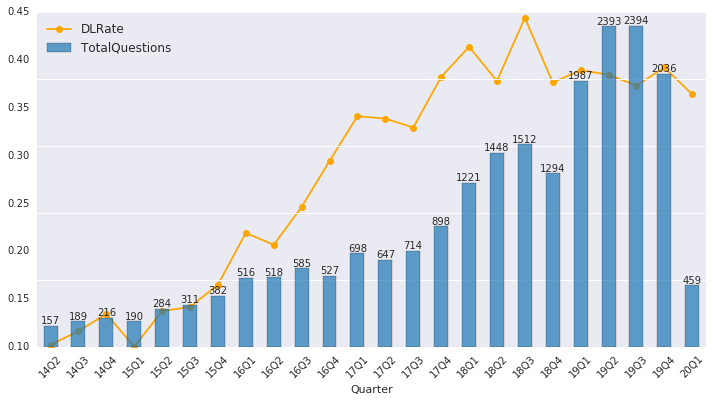

In [218]:
# Plot ratio of deep learning and number of all questions over time

ax1 = quarterly.plot(x="Quarter", y="DLRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(12,6)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, color='#1f77b4', alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

## Conclusion

The above figure shows that there is a trend of increasing questions about deep learning which started since 2015, and this trend seems to have saturated in 2018. There is no signatures that this trend is starting to diminish, so I conclude that I can recommend deep learning as a primal topic to write about on the blog.